# Linear regression baseline

In this notebook, we will create the linear regression baselines.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns
import pickle
from src.score import *
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook as tqdm

In [3]:
sns.set_style('darkgrid')
sns.set_context('notebook')

In [4]:
def to_pickle(obj, fn):
    with open(fn, 'wb') as f:
        pickle.dump(obj, f)
def read_pickle(fn):
    with open(fn, 'rb') as f:
        return pickle.load(f)

## Load and prepare data for training

First up, we need to load and prepare the data so that we can feed it into our linear regression model.

In [5]:
DATADIR = '/data/WeatherBench/5.625deg/'
PREDDIR = '/data/WeatherBench/baselines/'
# DATADIR = '/data/stephan/WeatherBench/5.625deg/'
# PREDDIR = '/data/stephan/WeatherBench/baselines/'

In [6]:
# Load the entire dataset for the relevant variables
z500 = xr.open_mfdataset(f'{DATADIR}geopotential_500/*.nc', combine='by_coords').z
t850 = xr.open_mfdataset(f'{DATADIR}temperature_850/*.nc', combine='by_coords').t.drop('level')
tp = xr.open_mfdataset(f'{DATADIR}total_precipitation/*.nc', combine='by_coords').tp.rolling(time=6).sum()
tp.name = 'tp'
t2m = xr.open_mfdataset(f'{DATADIR}2m_temperature/*.nc', combine='by_coords').t2m
data = xr.merge([z500, t850, tp, t2m])

In [7]:
# Load the validation subset of the data: 2017 and 2018
z500_test = load_test_data(f'{DATADIR}geopotential_500', 'z')
t850_test = load_test_data(f'{DATADIR}temperature_850', 't')
tp_test = load_test_data(f'{DATADIR}total_precipitation', 'tp').rolling(time=6).sum()
tp_test.name = 'tp'
t2m_test = load_test_data(f'{DATADIR}2m_temperature', 't2m')
test_data = xr.merge([z500_test, t850_test, tp_test, t2m_test])

In [8]:
# The first 7+6 values of tp are missing, so let's just start after that
data.tp[:6+7+1].mean(('lat', 'lon')).compute()

/home/rasp/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray 'tp' (time: 14)>
array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan, 0.00057716, 0.00058575], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 ... 1979-01-01T13:00:00
    level    int32 500

In [9]:
data = data.isel(time=slice(7+6, None))

In [10]:
# Split into train and test data
# Yes, technically we should have a separate validation set but for LR this shouldn't matter.
data_train = data.sel(time=slice('1979', '2016'))
# data_train = data.sel(time=slice('2016', '2016'))
data_test = data.sel(time=slice('2017', '2018'))

In [11]:
# Compute normalization statistics
# Let's only take a sample of the time to speed this up.
data_mean = data_train.isel(time=slice(0, None, 10000)).mean().load()
data_std = data_train.isel(time=slice(0, None, 10000)).std().load()

In [12]:
# Normalize datasets
data_train = (data_train - data_mean) / data_std
data_test = (data_test - data_mean) / data_std

In [13]:
_, nlat, nlon = data_train.z.shape; nlat, nlon

(32, 64)

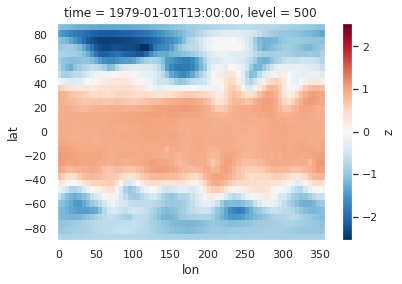

In [14]:
data_train.z.isel(time=0).plot()

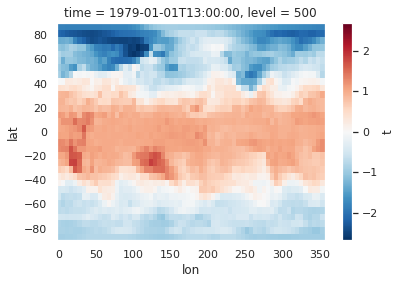

In [15]:
data_train.t.isel(time=0).plot()

In [16]:
data_train

,Array,Chunk
Bytes,2.73 GB,71.96 MB
Shape,"(333107, 32, 64)","(8784, 32, 64)"
Count,276 Tasks,38 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,2.73 GB,71.96 MB
Shape,"(333107, 32, 64)","(8784, 32, 64)"
Count,276 Tasks,38 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [17]:
def create_training_data(da, lead_time_h, return_valid_time=False):
    """Function to split input and output by lead time."""
    X = da.isel(time=slice(0, -lead_time_h))
    y = da.isel(time=slice(lead_time_h, None))
    valid_time = y.time
    if return_valid_time:
        return X.values.reshape(-1, nlat*nlon), y.values.reshape(-1, nlat*nlon), valid_time
    else:
        return X.values.reshape(-1, nlat*nlon), y.values.reshape(-1, nlat*nlon)

## Train linear regression

Now let's train the model. We will use scikit-learn for this.

In [18]:
def train_lr(lead_time_h, input_vars, output_vars, data_subsample=1):
    """Create data, train a linear regression and return the predictions."""
    X_train, y_train, X_test, y_test = [], [], [], []
    for v in input_vars:
        X, y = create_training_data(
            data_train[v],
            lead_time_h
        )
        
        X_train.append(X)
        if v in output_vars: y_train.append(y)
        X, y, valid_time = create_training_data(data_test[v], lead_time_h, return_valid_time=True)
        X_test.append(X)
        if v in output_vars: y_test.append(y)
    X_train, y_train, X_test, y_test = [np.concatenate(d, 1) for d in [X_train, y_train, X_test, y_test]]
    
    X_train = X_train[::data_subsample]
    y_train = y_train[::data_subsample]
    
    lr = LinearRegression(n_jobs=16)
    lr.fit(X_train, y_train)
    
    mse_train = mean_squared_error(y_train, lr.predict(X_train))
    mse_test = mean_squared_error(y_test, lr.predict(X_test))
    print(f'Train MSE = {mse_train}'); print(f'Test MSE = {mse_test}')
    preds = lr.predict(X_test).reshape((-1, len(output_vars), nlat, nlon))
    
    fcs = []
    for i, v in enumerate(output_vars):
        fc = xr.DataArray(
            preds[:, i] * data_std[v].values + data_mean[v].values, 
            dims=['time', 'lat', 'lon'],
            coords={
                'time': valid_time,
                'lat': data_train.lat,
                'lon': data_train.lon
            },
            name=v
        )
        fcs.append(fc)
    return xr.merge(fcs), lr   

### 3 days

Here we train a model to directly predict the fields at 3 days lead time. Let's train a model that only predicts z or t and then a combined model. As we can see below, the model trained only on Z500 performs better than the combined model. But the same is not the case for T850. For the paper, we will use the combined model.

In [26]:
experiments = [
    [['z'], ['z']],
    [['t'], ['t']],
    [['z', 't'], ['z', 't']],
    [['tp'], ['tp']],
    [['z', 't', 'tp'], ['tp']],
    [['t2m'], ['t2m']],
    [['z', 't', 't2m'], ['t2m']],
]

In [27]:
# Since training the LR on the full data takes up quite a lot of memory 
# we only take every 5th time step which gives almost the same results (<0.5% difference)
data_subsample = 5
lead_time = 3*24
preds = []
models = []
for n, (i, o) in enumerate(experiments):
    print(f'{n}: Input variables = {i}; output variables = {o}')
    p, m = train_lr(lead_time, input_vars=i, output_vars=o, data_subsample=data_subsample)
    preds.append(p); models.append(m)
    r = compute_weighted_rmse(p, test_data).compute()
    print('; '.join([f'{v} = {r[v].values}' for v in r]) + '\n')
    p.to_netcdf(f'{PREDDIR}/lr_3d_{"_".join(i)}_{"_".join(o)}.nc');
    to_pickle(m, f'{PREDDIR}/saved_models/lr_3d_{"_".join(i)}_{"_".join(o)}.pkl')

0: Input variables = ['z']; output variables = ['z']
Train MSE = 0.047421716153621674
Test MSE = 0.05775315687060356
z = 693.2920916695729

1: Input variables = ['t']; output variables = ['t']
Train MSE = 0.04175624996423721
Test MSE = 0.05174350365996361
t = 3.1919324223228887

2: Input variables = ['z', 't']; output variables = ['z', 't']
Train MSE = 0.03748195990920067
Test MSE = 0.05694284290075302
z = 714.9519994330979; t = 3.189890406083949

3: Input variables = ['tp']; output variables = ['tp']
Train MSE = 0.7977886199951172
Test MSE = 1.054569959640503
tp = 0.002328788147613836

4: Input variables = ['z', 't', 'tp']; output variables = ['tp']
Train MSE = 0.688325047492981
Test MSE = 1.153645396232605
tp = 0.0024336894867771327

5: Input variables = ['t2m']; output variables = ['t2m']
Train MSE = 0.015489773824810982
Test MSE = 0.019752398133277893
t2m = 2.3953812203180607

6: Input variables = ['z', 't', 't2m']; output variables = ['t2m']
Train MSE = 0.011629346758127213
Test M

As we can see the models with just the output variable as input almost always perform better because of overfitting. We could try a regularized regression like ridge of lasso but the point of these models not to be good but rather to provide a solid baseline with as few hyperparameters as possible.

In [28]:
# Same for 5 days
data_subsample = 5
lead_time = 5*24
preds = []
models = []
for n, (i, o) in enumerate(experiments):
    print(f'{n}: Input variables = {i}; output variables = {o}')
    p, m = train_lr(lead_time, input_vars=i, output_vars=o, data_subsample=data_subsample)
    preds.append(p); models.append(m)
    r = compute_weighted_rmse(p, test_data).compute()
    print('; '.join([f'{v} = {r[v].values}' for v in r]) + '\n')
    p.to_netcdf(f'{PREDDIR}/lr_5d_{"_".join(i)}_{"_".join(o)}.nc');
    to_pickle(m, f'{PREDDIR}/saved_models/lr_5d_{"_".join(i)}_{"_".join(o)}.pkl')

0: Input variables = ['z']; output variables = ['z']
Train MSE = 0.05985911563038826
Test MSE = 0.07377636432647705
z = 783.048846860714

1: Input variables = ['t']; output variables = ['t']
Train MSE = 0.048178404569625854
Test MSE = 0.06070050969719887
t = 3.439530277035071

2: Input variables = ['z', 't']; output variables = ['z', 't']
Train MSE = 0.046257924288511276
Test MSE = 0.07199461758136749
z = 814.6603554764138; t = 3.5229546158256353

3: Input variables = ['tp']; output variables = ['tp']
Train MSE = 0.803996205329895
Test MSE = 1.062649130821228
tp = 0.00233752970513597

4: Input variables = ['z', 't', 'tp']; output variables = ['tp']
Train MSE = 0.6962897777557373
Test MSE = 1.172526478767395
tp = 0.0024531068049946053

5: Input variables = ['t2m']; output variables = ['t2m']
Train MSE = 0.018064960837364197
Test MSE = 0.023729275912046432
t2m = 2.604655216350416

6: Input variables = ['z', 't', 't2m']; output variables = ['t2m']
Train MSE = 0.013758870773017406
Test MSE

### Iterative forecast

Finally, an iterative forecast. First, we train a model for 6 hours lead time and then construct an iterative forecast up to 120 hours.

In [22]:
def create_iterative_fc(state, model, lead_time_h=6, max_lead_time_h=5*24):
    max_fc_steps = max_lead_time_h // lead_time_h
    fcs_z500, fcs_t850 = [], []
    for fc_step in tqdm(range(max_fc_steps)):
        state = model.predict(state)
        fc_z500 = state[:, :nlat*nlon].copy() * data_std.z.values + data_mean.z.values
        fc_t850 = state[:, nlat*nlon:].copy() * data_std.t.values + data_mean.t.values
        fc_z500 = fc_z500.reshape((-1, nlat, nlon))
        fc_t850 = fc_t850.reshape((-1, nlat, nlon))
        fcs_z500.append(fc_z500); fcs_t850.append(fc_t850)

    return [xr.DataArray(
        np.array(fcs), 
        dims=['lead_time', 'time', 'lat', 'lon'],
        coords={
            'lead_time': np.arange(lead_time_h, max_lead_time_h + lead_time_h, lead_time_h),
            'time': z500_test.time,
            'lat': z500_test.lat,
            'lon': z500_test.lon
        }
    ) for fcs in [fcs_z500, fcs_t850]]

In [31]:
p, m = train_lr(6, input_vars=['z', 't'], output_vars=['z', 't'], data_subsample=5)

Train MSE = 0.0033889012411236763
Test MSE = 0.0042942301370203495


In [33]:
to_pickle(m, f'{PREDDIR}/saved_models/lr_6h_z_t_z_t.pkl')

In [19]:
m = read_pickle(f'{PREDDIR}/saved_models/lr_6h_z_t_z_t.pkl')

/home/rasp/miniconda3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LinearRegression from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [20]:
state = np.concatenate([data_test.z.values.reshape(-1, nlat*nlon), 
                        data_test.t.values.reshape(-1, nlat*nlon)], 1)

In [23]:
fc_z500_6h_iter, fc_t850_6h_iter = create_iterative_fc(state, m)

/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [26]:
fc_iter = xr.Dataset({'z': fc_z500_6h_iter, 't': fc_t850_6h_iter})
fc_iter.to_netcdf(f'{PREDDIR}/lr_6h_iter.nc');

# The End